---

title: **Temporal Consistency Analysis**\
author: *Tiago Ribeiro*\
date: 04/05/2022

---


**Libraries**

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt              
from os import getcwd                     # gets working directory   
from os.path import join
from glob import glob

import geopandas as gpd               # to plot geometries

from rasterio.features import shapes  # gets shapes and values of regions 
from rasterio import Affine           # affine planar transformations

from shapely import wkt                     # working with WKT files
from shapely.geometry import Polygon        # surfaces
from shapely.geometry import Point          # points
from shapely.geometry import MultiPolygon   # collection of surfaces (Polygon)
from shapely.geometry import shape          # convertion to Shapely geometry
from shapely.geometry import mapping        # convertion to GeoJSON-like mapping
from shapely.affinity import scale          # returns scaled geometry
from shapely.ops import unary_union         # cumulative union of objects

**File Paths**

In [11]:
DIR = getcwd() 

SEGS_DIR = 'D:\BurnedAreaUAV_files\BurnedAreaUAV_dataset\Results'
SEGS_BASE_DIR = join(SEGS_DIR, 'segs_base')
SEGS_RED_DIR = join(SEGS_DIR, 'segs_red')
SEGS_3D_DIR = join(SEGS_DIR, 'segs_3d')

#SEGS_REF_DIR = join(DIR, 'data\mscs_ref') 

segs_base = sorted(glob(join(SEGS_BASE_DIR, "*.png")))
segs_red = sorted(glob(join(SEGS_RED_DIR, "*.png")))
segs_3d = sorted(glob(join(SEGS_3D_DIR, "*.png")))

#segs_ref = sorted(glob(join(SEGS_REF_DIR, "*.png")))

**Functions**

In [12]:
def mask_to_polygons(mask_img):
    """
    Converts segmentation mask to shapely multipolygon.

    Adapted from: https://rocreguant.com/convert-a-mask-into-a-polygon-for-images-using-shapely-and-rasterio/1786/
    """
    all_polygons = list()
    
    for shp, value in shapes(source=mask_img.astype(np.uint8),mask=(mask_img>0), 
                             transform=Affine(1.0, 0, 0, 0, 1.0, 0)):
        all_polygons.append(shape(shp))

    all_polygons = MultiPolygon(all_polygons)

    # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
    # need to keep it a Multipolygon throughout
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    
    return all_polygons

def msks_paths_to_polygon_list(msks_paths):
    """
    Converts segmentation masks paths list to list of shapely multipolygons.
    """
    pol_list = list()
    for img_path in msks_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        polygon = mask_to_polygons(img)
        pol_list.append(polygon)
    return pol_list

def norm_area_diff(pol_list):
    """
     Takes a list of Shapely Polygons and calculates Normalized Area Difference
     for every consecutive polygons
    """
    norm_area_diff_list = list()
    for i in range(len(pol_list)-1):
        dif = pol_list[i].difference(pol_list[i+1])
        norm_area_diff_list.append(dif.area/pol_list[i+1].area)

    return norm_area_diff_list

**U-Net Base Segmentations**

In [13]:
%%time
pol_list = msks_paths_to_polygon_list(segs_base)
nad_base = norm_area_diff(pol_list)

CPU times: total: 2min 10s
Wall time: 6min 52s


**U-Net RED Segmentations**

In [14]:
%%time
pol_list = msks_paths_to_polygon_list(segs_red)
nad_red = norm_area_diff(pol_list)

CPU times: total: 1min 51s
Wall time: 6min 40s


**U-Net 3D Segmentations**

In [15]:
%%time
pol_list = msks_paths_to_polygon_list(segs_3d)
nad_3d = norm_area_diff(pol_list)

CPU times: total: 1min 25s
Wall time: 5min 39s


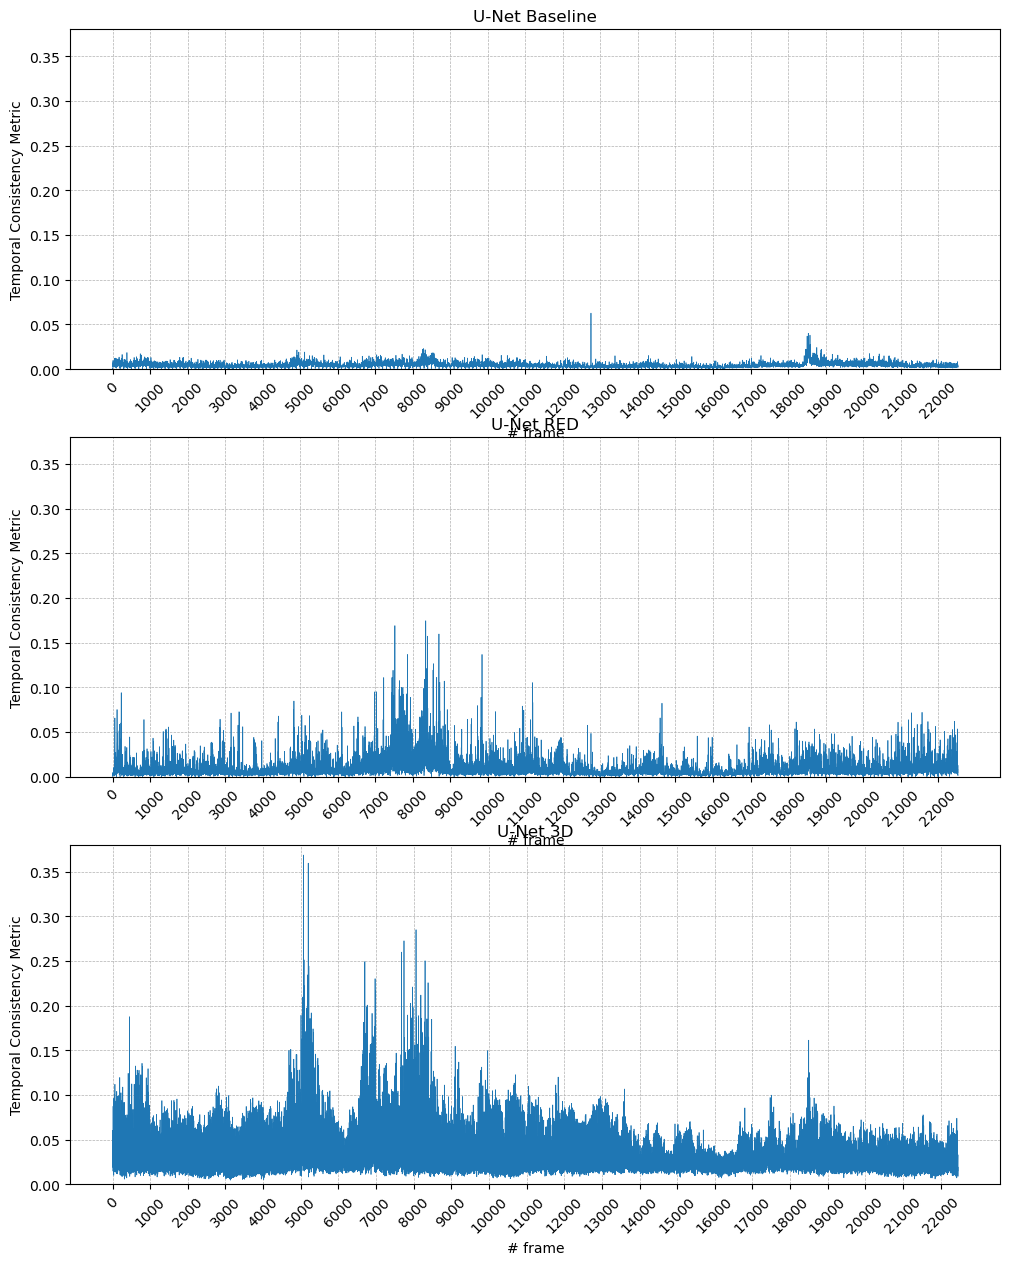

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12,15))
ax0.plot(nad_base, linewidth=0.5)
ax1.plot(nad_red, linewidth=0.5)
ax2.plot(nad_3d, linewidth=0.5)
y_lim = 0.38
ax0.set_ylim([0, y_lim])
ax1.set_ylim([0, y_lim])
ax2.set_ylim([0, y_lim])

ax0.set_title("U-Net Baseline")
# Generated Burned Area Temporal Consistency
ax0.set_xlabel('# frame')
labels = np.arange(0, len(nad_base), 1000)
labels_y = np.arange(0, y_lim, 0.05)
ax0.set_xticks(labels)
ax0.set_yticks(labels_y)
ax0.set_xticklabels(labels, rotation=45)
ax0.set_ylabel("Temporal Consistency Metric")
ax0.grid(linestyle = '--', linewidth = 0.5)

ax1.set_title("U-Net RED")
ax1.set_xlabel('# frame')
ax1.set_xticks(labels)
ax1.set_yticks(labels_y)
ax1.set_xticklabels(labels, rotation=45)
ax1.set_ylabel("Temporal Consistency Metric")
ax1.grid(linestyle = '--', linewidth = 0.5)

ax2.set_title("U-Net 3D")
ax2.set_xlabel('# frame')
ax2.set_xticks(labels)
ax2.set_yticks(labels_y)
ax2.set_xticklabels(labels, rotation=45)
ax2.set_ylabel("Temporal Consistency Metric")
ax2.grid(linestyle = '--', linewidth = 0.5)
